In [1]:
#CT image reconstruct through the FBP algorithm
#Written by Ren-Qi Pan
import math
import os
from pydicom import dcmread, dcmwrite
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
_pth = r"E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\VMAT 2025 - 1. CENTRAL TARGET\TRIAL 1\873251666"

In [3]:
_files = os.listdir(_pth)

In [4]:
dcm = dcmread(os.path.join(_pth, _files[0]))
shape = dcm.Rows, dcm.Columns

In [5]:
shape

(1190, 1190)

In [6]:
g_angle = []
_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)
prev = np.zeros((shape[0], shape[0]), dtype=np.int64)
curr = np.zeros((shape[0], shape[0]), dtype=np.int64)
_center_pixel = []
_raw_datas = []

_skip_images = 0
for idx, _f in enumerate(tqdm(np.sort(_files))):
    _fname = os.path.join(_pth, _f)
    raw = dcmread(_fname)
    curr = raw.pixel_array
    
    _m = curr - prev
    _center_pixel.append(_m[595,595])
    if np.max(abs(_m)) > 10000:
        # _images[idx, :, :] = _images[idx-1, :, :]
        # g_angle.append(g_angle[idx-1])
        
        _images[idx, :, :] = -np.abs(curr - prev)/10
        prev = curr
        g_angle.append(raw.GantryAngle)
        print(idx)
        # _skip_images += 1
        pass
    else:
        _images[idx, :, :] = curr - prev
        prev = curr
        g_angle.append(raw.GantryAngle)
        
    prev = curr


  0%|          | 0/432 [00:00<?, ?it/s]

 22%|██▏       | 94/432 [00:01<00:03, 103.03it/s]

68


 38%|███▊      | 166/432 [00:01<00:02, 111.23it/s]

149


 74%|███████▎  | 318/432 [00:03<00:01, 111.22it/s]

309


100%|██████████| 432/432 [00:04<00:00, 105.66it/s]


In [7]:
g_angle = np.array(g_angle)
sorted_inx = np.argsort(g_angle)

sorted_images = np.zeros((len(_files) -_skip_images,shape[0], shape[0]), dtype=np.uint16)

for idx, val in enumerate(tqdm(sorted_inx)):
    sorted_images[idx, :, :] = _images[val, :, :]

100%|██████████| 432/432 [00:00<00:00, 1206.29it/s]


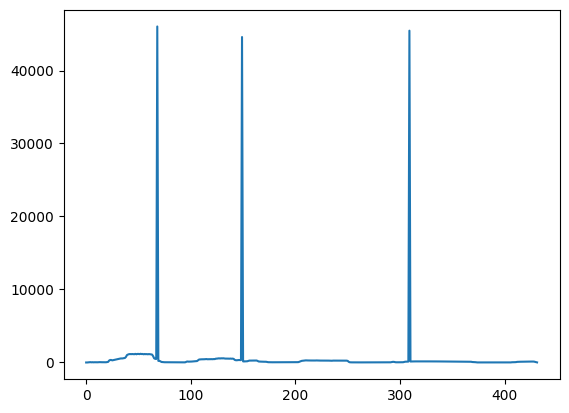

In [8]:
plt.plot(_center_pixel)

In [9]:
# asdf

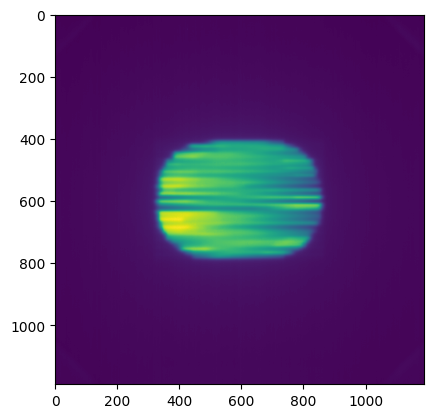

In [10]:
dcm_1 = dcmread(os.path.join(_pth, _files[72]))
plt.imshow(dcm_1.pixel_array)

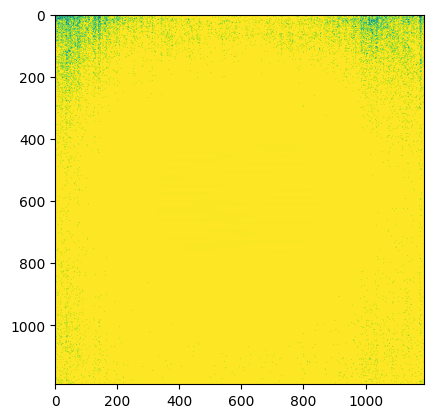

In [11]:
dcm_1 = dcmread(os.path.join(_pth, _files[71]))

dcm_2 = dcmread(os.path.join(_pth, _files[72]))
plt.imshow(-abs(dcm_2.pixel_array - dcm_1.pixel_array))

In [12]:
dcm_1.pixel_array

array([[206, 171, 171, ..., 250, 226, 261],
       [310, 193, 214, ..., 221, 280, 228],
       [139, 184, 179, ..., 260, 355, 348],
       ...,
       [563, 420, 504, ..., 501, 546, 532],
       [494, 428, 411, ..., 507, 476, 525],
       [582, 332, 421, ..., 465, 527, 564]], dtype=uint16)

In [13]:
_files[72]

'00144.dcm'

In [14]:
# sorted_images = _images
# g_angle2 = g_angle

In [15]:
g_angle2 = g_angle[sorted_inx]
_images = []



In [16]:
#define the filter function: Ram-Lak (R-L) filter and the Shepp-Logan(S-L) filter
#N:number of detector cells
#d: step width of detector cells
PI=math.pi

def filter_SL(N,d):
    fh_SL=np.zeros(N)
    for k1 in range(0,N,1):
        fh_SL[k1]=-2.0/(PI*PI*d*d*(4*(k1-N/2.0)**2-1))
    return fh_SL

def nearestPowerOf2(N):
    # Calculate log2 of N
    a = int(math.log2(N))
    if 2**a == N:
        return N
    return 2**(a + 1)

In [17]:
from scipy.fft import fft, ifft

def Fun_Weigth_Projection(projection_beta,SOD,delta_dd):
    Nrows,Ncolumns=projection_beta.shape
    dd_column=delta_dd*np.arange(-Ncolumns/2+0.5,(Ncolumns/2+1)-0.5,1.0)#coordinate of detector cell in horizontal 
    dd_row=delta_dd*np.arange(-Nrows/2+0.5,(Nrows/2+1)-0.5,1.0)#coordinate of detector cell in vertical
    dd_row2D,dd_column2D=np.meshgrid(dd_row,dd_column,indexing='ij')
    weighted_projection=projection_beta*SOD/np.sqrt(SOD*SOD+np.power(dd_row2D,2.0)+np.power(dd_column2D,2.0))
    return weighted_projection

def optimize_convolution(weighted_projection, fh_RL):
    Nrows, Ncolumns = weighted_projection.shape
    Nfft = nearestPowerOf2(2 * Ncolumns - 1)
    fh_RL_padded = np.zeros(Nfft)
    fh_RL_padded[:len(fh_RL)] = fh_RL / 2.0  # Scale and pad filter response
    
    fh_RL_fft = fft(fh_RL_padded)  # FFT of the filter response
    
    # Zero pad the input projection for FFT
    projection_padded = np.zeros((Nrows, Nfft))
    projection_padded[:, :Ncolumns] = weighted_projection

    # Perform FFT on each row of the projection
    projection_fft = fft(projection_padded, axis=1)
    
    # Element-wise multiplication in the frequency domain
    convoluted_freq = projection_fft * fh_RL_fft
    
    # Perform the inverse FFT to get back to the time domain
    convoluted_time = ifft(convoluted_freq, axis=1).real
    
    # Slice to obtain the result with the correct dimensions
    filtered_projection = convoluted_time[:, :Ncolumns]
    
    return filtered_projection


def Fun_Filter_Projection(weighted_projection,fh_RL):
    Nrows,Ncolumns=weighted_projection.shape
    Nfft=nearestPowerOf2(2*Ncolumns-1)
    filtered_projection=np.zeros((Nrows,Ncolumns))
    for row in range(Nrows):
        projection_row=weighted_projection[row,:]
        zeros_pad=np.zeros(Nfft-Ncolumns)
        projection_row=np.concatenate((projection_row,zeros_pad))
        convoluted_time=np.convolve(projection_row,fh_RL/2.0,mode='same')
        convoluted_time=convoluted_time[:Ncolumns]
        filtered_projection[row,:]=convoluted_time
    return filtered_projection

def Fun_BackProjection(filtered_projection,SOD,beta_num,beta_m,delta_dd,Nimage):
    Nrows,Ncolumns=filtered_projection.shape
    MX, MZ=Nimage,int(Nimage*Nrows/Ncolumns)
    #roi[0], roi[1]: the min and max of x-axis and y-axis
    #roi[2],roi[3]: the min and max of z-axis
    
    roi=delta_dd*np.array([-Ncolumns/2.0+0.5,Ncolumns/2.0-0.5,-Nrows/2.0+0.5,Nrows/2.0-0.5])
    hx=(roi[1]-roi[0])/(MX-1) #interval of x-axis and y-axis
    xrange=roi[0]+hx*np.arange(0,MX) #coordinate vector of x-axis and y-axis 
    hy=(roi[3]-roi[2])/(MZ-1) #interval of z-axis
    yrange=roi[2]+hy*np.arange(0,MZ) #coordinate vector of z-axis 
    XX,YY,ZZ=np.meshgrid(xrange,xrange,yrange,indexing='ij')
    temp_rec=np.zeros((MX,MX,MZ)) #store back projection contribution
    U=(SOD+XX*np.sin(beta_m)-YY*np.cos(beta_m))/SOD
    a=(XX*np.cos(beta_m)+YY*np.sin(beta_m))/U
    xx=np.int32(np.floor(a/delta_dd)) #beam numbering,strart from -Ncolumns/2
    u1=a/delta_dd-xx  #the decimal part of a
    b=ZZ/U
    yy=np.int32(np.floor(b/delta_dd)) #beam numbering,strart from -Nrows/2
    u2=b/delta_dd-yy #the decimal part of b
    xx=xx+int(Ncolumns/2) #numbering from 0
    yy=yy+int(Nrows/2) #numbering from 0

    mask=np.where((xx >=0) & (xx< Ncolumns-1) & (yy >=0) & (yy<Nrows-1))
    xx=xx[mask]
    yy=yy[mask]
    u1=u1[mask]
    u2=u2[mask]
    # print(mask)
    temp=(1-u1)*(1-u2)*filtered_projection[yy,xx]+(1-u1)*u2*filtered_projection[yy+1,xx]+\
                 (1-u2)*u1*filtered_projection[yy,xx+1]+u1*u2*filtered_projection[yy+1,xx+1]
    temp_rec[mask]=temp_rec[mask]+temp/(np.power(U[mask],2))*2*PI/beta_num
    print('backprojection, beta: ',round(beta_m*180/PI,1))
    return temp_rec


In [18]:
def ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd):
    # projection: projection data in 3D, (angle,row, colums)
    # fh_RL: R-L filter function
    # beta: rotate angles in degrees
    # SOD: source to rotation center distance in mm unit
    # delta_dd: interval of the virtual detector cell
    Ncolumns=projection.shape[2]
    Nrows=projection.shape[1]
    rec_image=np.zeros((Nimage,Nimage,int(Nimage*Nrows/Ncolumns)))
    beta_num=len(beta) #number of angles
    beta=beta*PI/180.0 # view angle in radian
    for m in range(0, beta_num,1):
        projection_beta=projection[m,:,:] #projection matrix at the beta angle
        weighted_projection=Fun_Weigth_Projection(projection_beta,SOD,delta_dd)
        filtered_projection=optimize_convolution(weighted_projection,fh_RL)
        rec_image=rec_image+Fun_BackProjection(weighted_projection,SOD,beta_num,beta[m],delta_dd,Nimage)
        # break
    return rec_image

In [19]:
sorted_images.shape

(432, 1190, 1190)

In [20]:
Ncolumns = sorted_images.shape[2]

In [21]:
SID = dcm.RTImageSID
SAD = dcm.RadiationMachineSAD

In [22]:
Nimage=100 #size of image
beta=np.float32(g_angle2) #rotate(view) angles
SOD=SAD#source to origin distance, in unit mm
SDD=SID #source to center of detector, in unit mm
width=0.172 #size of detector cell, in unit mm
delta_dd=width*SOD/SDD #interval of the virtual detector cell
Nfft=nearestPowerOf2(2*Ncolumns-1) #number of points for FFT
fh_RL=filter_SL(Nfft,delta_dd)  #get the filter kernel function
#reconstruct the scanned object through the FBP algorithm
rec_image=ConeBeam_FDK_Backprojection(sorted_images,fh_RL,beta,SOD,Nimage,delta_dd)

backprojection, beta:  0.1
backprojection, beta:  1.0
backprojection, beta:  1.9
backprojection, beta:  2.8
backprojection, beta:  3.7
backprojection, beta:  4.6
backprojection, beta:  5.4
backprojection, beta:  6.1
backprojection, beta:  6.9
backprojection, beta:  7.7
backprojection, beta:  8.4
backprojection, beta:  9.1
backprojection, beta:  9.9
backprojection, beta:  10.6
backprojection, beta:  11.4
backprojection, beta:  12.1
backprojection, beta:  12.9
backprojection, beta:  13.6
backprojection, beta:  14.4
backprojection, beta:  15.1
backprojection, beta:  15.9
backprojection, beta:  16.6
backprojection, beta:  17.4
backprojection, beta:  18.1
backprojection, beta:  18.9
backprojection, beta:  19.6
backprojection, beta:  20.4
backprojection, beta:  21.1
backprojection, beta:  21.9
backprojection, beta:  22.6
backprojection, beta:  23.3
backprojection, beta:  24.1
backprojection, beta:  24.8
backprojection, beta:  25.6
backprojection, beta:  26.3
backprojection, beta:  27.0
backp

In [28]:
rec_image = np.transpose(rec_image, (2, 1, 0))


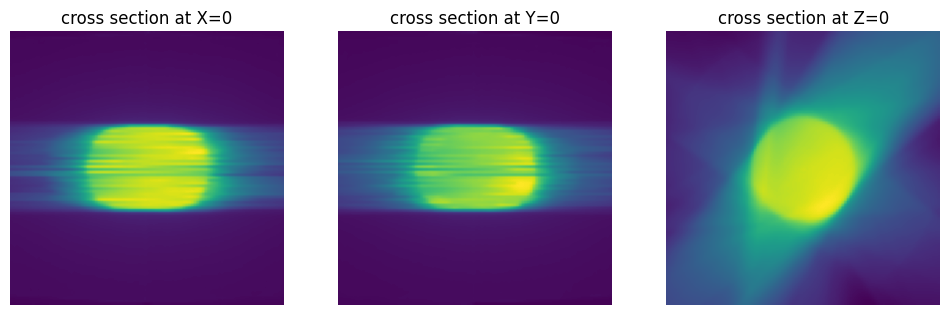

In [32]:
NimageZ=Nimage*sorted_images.shape[0]/sorted_images.shape[0]
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(rec_image[X_c,:,:].T, cmap='viridis')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(rec_image[:,Y_c,:].T, cmap='viridis')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(rec_image[:,:,60].T, cmap='viridis')
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

In [25]:
_TPS_pth = r"E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\3DDose\EPID_12_t0.dcm"

tps_dcm = dcmread(_TPS_pth)
tps_image = tps_dcm.pixel_array

In [26]:
# Uncomment to save the reconstructed volume as DICOM
# try:
#     if 'tps_dcm' in locals():
        # Scale and prepare for DICOM export
scaled_image = np.int32(rec_image * 1)

# Create new DICOM based on TPS template
write_dicom = tps_dcm.copy()
write_dicom.NumberOfFrames = str(rec_image.shape[2])
write_dicom.Rows = rec_image.shape[0]
write_dicom.Columns = rec_image.shape[1]
write_dicom.PixelData = scaled_image.tobytes()

# Save with timestamp
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = f"E:\\CMC\\pyprojects\\radio_therapy\\dose-3d\\dataset\\3DDose\\EPID_CENTRAL_DIVB10.dcm"
dcmwrite(output_path, write_dicom)
print(f"\nOptimized reconstruction saved to: {output_path}")
#     else:
#         print("TPS data not available - cannot save DICOM")
# except Exception as e:
#     print(f"Error saving DICOM: {e}")

# print("\nOptimized reconstruction complete!")


Optimized reconstruction saved to: E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\3DDose\EPID_CENTRAL_DIVB10.dcm


In [27]:
# _TPS_pth = r"C:\Users\Pintu\OneDrive - Christian Medical College\Fabricated Phantom Rotational RT\RT Dose and Plan\Rotational Arc_Fabricated Phantom CT plans\RD.23022024.3ARCs.dcm"

# tps_dcm = dcmread(_TPS_pth)
# tps_image = tps_dcm.pixel_array
